# Panorama creator

Ce carnet décrit les étapes de développement du script python Panorama Creator, développé dans le cadre du mini-projet de la partie « _Traitement d'images 2D_ » du cours d'analyse des images (`USRS5G`) à l'ENJMIN dispensé par Nicolas Audebert.

### Auteurs
 - Colin BERNARD : [https://github.com/colpiche](https://github.com/colpiche)
 - Lucas LE DUDAL : [https://github.com/Cava3](https://github.com/Cava3)

### Cours
[https://github.com/nshaud/stmn-analyse-images-2D](https://github.com/nshaud/stmn-analyse-images-2D)

### Consigne du projet
Sujet 8 - création de panoramas : [https://github.com/nshaud/stmn-analyse-images-2D/blob/main/projets.md](https://github.com/nshaud/stmn-analyse-images-2D/blob/main/projets.md)

## Objet

«_L'objectif de ce mini-projet est crééer automatiquement des panoramas, par exemple à 360°, en combinant plusieurs photos prises depuis le même point de vue._»

Nous avons pour cela utilisé la formidable bibliothèque de traitement d'image `scikit-image` vue en cours.

## Prérequis

Le code livré ici est fonctionnel mais requiert certaines conditions pour donner des résultats corrects :
 - il a été pensé pour créer des panoramiques horizontaux, la création de panoramiques verticaux ou en grille n'ont pas été testée et ne sera sans doute pas satisfaisante
 - l'ordre des images dans le panorama final doit correspondre à l'ordre des éléments de la liste `l_images`. Pas de parcourt automatique de dossier ici, que des noms de fichiers codés en dur
 - les images doivent avoir été capturées depuis le même point de vue, idéalement avec le centre optique de la caméra toujours à la même position. Les images fournies ici ont été capturées en effectuant une translation de la caméra et pas de rotation, certaines perspectives ont donc été déformées (notamment celles des objets en avant-plan) et on constate alors une discontinuité des lignes et des formes sur l'assemblage final
 - les définitions des images ne doivent pas être trop grandes, les images utilisées ici ont une résolution de 563x1000 pixels. Des images en pleine résolution augmenteraient considérablement le temps de calcul des correspondances des points, bien que les résultats seraient sûrement meilleurs

## Améliorations possibles

 - soft blending lors de la fusion de 2 images
 - correction colorimétrique des images à fusionner pour faire correspondre leurs profils de couleurs, selon la méthode de transfert de couleurs vue à la fin du TP0
 - extraction précise de l'angle de rotation de la transformation affine appliquée à l'image 2 en vue de la rogner pour couper les zones noires apparues suites à la rotation. Pour l'instant l'angle extrait n'est pas cohérent visuellement (piste : l'axe de référence, le 0°, est-il vraiment vertical ?)

## Etapes de développement

### Initialisation

On importe tranquillement les librairies et les images sur lesquelles on va travailler.

In [3]:
from skimage import io

img_1 = io.imread("images/small_image1.jpg")
img_2 = io.imread("images/small_image2.jpg")

### Détection des points d'intérêt

On utilise l'algorithme ORB pour détecter les points d'intérêt des images et extraire leurs descripteurs. On lui passe les images en niveaux de gris car la fonction n'accepte que des arrays 2D, autrement dit des images avec un seul canal.

In [6]:
from skimage.feature import ORB
from skimage.color import rgb2gray

orb = ORB()

orb.detect_and_extract(rgb2gray(img_1))
keypoints_1 = orb.keypoints
descriptors_1 = orb.descriptors

orb.detect_and_extract(rgb2gray(img_2))
keypoints_2 = orb.keypoints
descriptors_2 = orb.descriptors

### Appariemment des point d'intérêt

On utilise la fonction `match_descriptors` qui implémente le calcul de la somme des carrés des différences des sous-fenêtres centrées sur les points d'intérêt.

In [7]:
from skimage import feature

matches = feature.match_descriptors(descriptors_1,
                                    descriptors_2,
                                    metric="hamming",
                                    cross_check=True)

if keypoints_1 is None or keypoints_2 is None:
    print("No keypoints found")
    exit(0)

### Estimation de la matrice d'homographie

On utilise l'algorithme RANSAC pour faire le tri dans les correspondances et garder uniquement celles qui sont correctes. C'est lui qui nous fournit la matrice d'homographie correspondante.
On estime que l'homothétie n'est pas plus complexe qu'une similitude, pour avoir besoin d'aller chercher une transformation affine voire une application projective il aurait fallu que l'objectif introduise des distorsions dans l'image. On admettra que ce n'est pas le cas ici.

In [8]:
from skimage.measure import ransac
from skimage import transform

src = keypoints_1[matches[:, 0]][:, ::-1]
dst = keypoints_2[matches[:, 1]][:, ::-1]

model_robust, inliers = ransac((src, dst),
                                transform.SimilarityTransform,
                                min_samples=3,
                                residual_threshold=2,
                                max_trials=100)

### Application de la transformation

On applique la transformation à l'image de droite (`img_2`) d'après la matrice fournie par RANSAC. La fonction `warp` renvoie une image codée en `float`, on la convertit alors en `int` avec la fonction `img_as_ubyte` pour rester en cohérence avec le reste de la chaine de traitement.
On règle le paramètre `output_shape` de telle sorte à créer comme un canvas ayant pour largeur la somme des largeurs des 2 images, permettant ainsi à l'image subissant la transformation d'être translatée, tournée ou dilatée sans perdre de pixels en largeur.

In [9]:
from skimage.util import img_as_ubyte

img_2_warped = img_as_ubyte(
        transform.warp(img_2,
                       model_robust,
                       output_shape=(img_1.shape[0],
                                     img_1.shape[1] + img_2.shape[1])))

### Assemblage des images

On vient ensuite assembler les images à l'aide du slicing de Numpy, l'image de gauche (`img_1`) est « plaquée » sur l'image de droite (`img_2`).

In [11]:
import numpy as np

result = np.copy(img_2_warped)
result[:img_1.shape[0], :img_1.shape[1]] = img_1

On passe ensuite l'image assemblée à une fonction `trim_image` qui la découpera pour enlever les zones noires crées précédemment lors de l'application de la transformation.
C'est la fonction `nonzero` de Numpy qui retourne les index des lignes et colonnes de la matrice contenant des valeurs autres que 0. On se sert de ces coordonnées pour slicer l'image et retirer les lignes et colonnes totalement noires.
On ajoute au slicing horizontal un nombre de pixels `x_offset` déterminé en fonction de l'angle de la rotation appliquée à l'image transformée afin de couper l'image assemblée à l'intérieur du coté en diagonal et pas en extérieur, ce qui laisserait un triangle noir sur l'image finale.

Actuellement l'angle extrait du modèle n'est pas le bon, ce qui a pour effet de laisser des zones noires dans certains cas. En attendant de trouver la solution nous avons appliqué un coefficient de sécurité de 2 au nombre de pixels à couper. On peut se permettre ici d'en supprimer plus que nécessaire car l'on admet que la zone de recouvrement avec la prochaine image à assembler sera suffisamment importante pour rendre cette perte négligeable.


In [12]:
import math

def trim_image(image, x_offset=0):
    mask = image == 0
    rows = np.nonzero((~mask).sum(axis=1))
    cols = np.nonzero((~mask).sum(axis=0))
    trimmed = image[rows[0].min():rows[0].max()+1,
                    cols[0].min():cols[0].max()-x_offset,
                    :]
    return trimmed

x_offset = 2 * int(abs(img_2.shape[0] * math.tan(model_robust.rotation)))
result = trim_image(result, x_offset)

On obtient alors notre image assemblée.

Text(0.5, 1.0, 'Image assemblée')

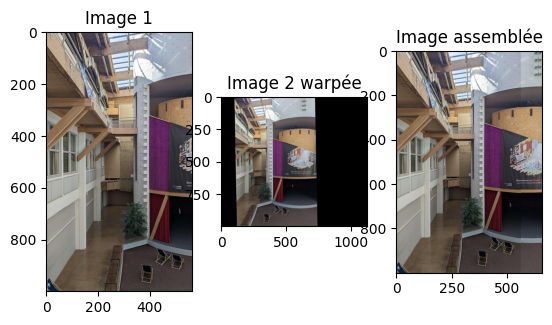

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(img_1)
ax[0].set_title("Image 1")
ax[1].imshow(img_2_warped)
ax[1].set_title("Image 2 warpée")
ax[2].imshow(result)
ax[2].set_title("Image assemblée")

Cette image assemblée sera ensuite utilisée comme image à fusionner avec la prochaine photo, et on itère ainsi de suite jusqu'à épuisement des images à assembler.

En réalité l'algorithme final assemble les photos de droite à gauche. Cela permet 
de gagner en précision lors de l'appariemment des points de correspondance puisque leur recherche se fait sur une zone beaucoup plus grande. En effet, la partie gauche de l'image assemblée à l'itération n-1 est en réalité l'image 1 entière de cette itération n-1. A l'origine l'algorithme assemblait les images de gauche à droite mais comme chaque itération rajoutait une fine bande supplémentaire sur la droite de l'image, et en tenant compte des erreurs dans l'estimation de la matrice d'homographie, les estimations lors des itérations suivantes étaient très mauvaises voire n'aboutissaient pas du tout.
